### **CMPE 257 Assignment 4 - Latent Manifold**
**Dataset:** 
eCommerce customer behavior data

https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store

**Market segmentation** is important for small scale businesses to filter out their target markets. This can include segments of users whom they can target in order to increase sales, or segments of products that they can replace to increase their income.

**Latent Variable used:**
Popularity factor based on the category codes in demand.


# **Data collection and preparation**

In [ ]:
from io import BytesIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow.compat.v1 as tf
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vTrfrhv1SOGSa0cLry-16Tx4ykJZBRDDjtCCJJzai0OtB8ewYbmzcSyNBSqvARAqHppa_NM1LH1-MEC/pub?gid=1654498000&single=true&output=csv')
data = r.content
df_Oct = pd.read_csv(BytesIO(data))
df_Oct = df_Oct.drop(columns='Unnamed: 0', axis=1)

In [ ]:
df_Oct.shape

(50000, 9)

In [ ]:
df_Oct.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


# **Data wrangling**

In [ ]:
# Checking for null values in df
df_Oct.isnull().sum()

event_time           0
event_type           0
product_id           0
category_id          0
category_code    16098
brand             7041
price                0
user_id              0
user_session         0
dtype: int64

### **Column: category_code**

In [ ]:
##Replace all null values in the 'category_code' column
df_Oct.category_code = df_Oct.category_code.replace(np.nan,'Not Available')

### **Column: brand**

In [ ]:
##Replace all null values in the 'brand column'
df_Oct.brand = df_Oct.brand.replace(np.nan,'Not Available')

### **Column: event_time**

In [ ]:
##Converting the date type to datetime type for 'event_time'
df_Oct['event_time'] = pd.to_datetime(df_Oct['event_time'], format='%Y-%m-%d %H:%M:%S UTC')

In [ ]:
##Splitting event_time into 2 columns containing date and time respectively
df_Oct['transaction_time'] = df_Oct['event_time'].dt.time
df_Oct['transaction_date'] = df_Oct['event_time'].dt.normalize()

### **product_id**

In [ ]:
## Counting how many unique products are in the dataset
print('The total count for product id is:',df_Oct['product_id'].count())
print('The total unique count for product id is:',len(df_Oct['product_id'].unique()))

The total count for product id is: 50000
The total unique count for product id is: 13289


### **user_id**

In [ ]:
## Counting how many unique products are in the dataset
print('The total count for user id is:',df_Oct['user_id'].count())
print('The total unique count for user id is:',len(df_Oct['user_id'].unique()))

The total count for user id is: 50000
The total unique count for user id is: 10931


### **price**

In [ ]:
#using the describe method on column 'price' to ensure that there are no negative values
df_Oct['price'].describe()

count    50000.000000
mean       285.880781
std        361.302612
min          0.000000
25%         60.230000
50%        154.410000
75%        356.250000
max       2574.070000
Name: price, dtype: float64

In [ ]:
# Ensure all the 'null' values are taken care of
df_Oct.isnull().sum()

event_time          0
event_type          0
product_id          0
category_id         0
category_code       0
brand               0
price               0
user_id             0
user_session        0
transaction_time    0
transaction_date    0
dtype: int64

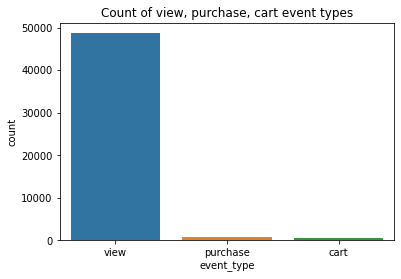

In [ ]:
#Count of event types
plt.title('Count of view, purchase, cart event types')
sns.countplot(x = 'event_type', data = df_Oct)

In [ ]:
df_Oct['event_type'].replace({
    'view': 0,
    'cart': 0,
    'purchase': 1}, inplace = True
)

In [ ]:
#creating two dataframes with purchased users and non purchased users

purchased_set = df_Oct[df_Oct['event_type']==1]
purchased_set.shape[0]

non_purchased_set = df_Oct[df_Oct['event_type']==0]
non_purchased_set.shape[0]

49252

In [ ]:
from sklearn.utils import resample

#equally sampling 150 data points from each

n_samples = 150
puchased_sampled = resample(purchased_set,
                                    replace=False,
                                    n_samples=n_samples,
                                    random_state=27)
not_purchased_sampled = resample(non_purchased_set,
                                     replace=False,
                                     n_samples=n_samples,
                                     random_state=27
                                     )

In [ ]:
#creating a dataframe sampled by concatenating purchased and not purchased sampled dataframes

sampled = pd.concat([puchased_sampled, not_purchased_sampled])
sampled['event_type'].value_counts()

1    150
0    150
Name: event_type, dtype: int64

In [ ]:
sampled.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,transaction_time,transaction_date
24097,2019-10-01 03:00:00,1,1004211,2053013555631882655,electronics.smartphone,samsung,97.79,550679725,bf8afaeb-5a57-47f0-b769-4082a4f84562,03:00:00,2019-10-01
21335,2019-10-01 02:56:04,1,1005104,2053013555631882655,electronics.smartphone,apple,975.57,555160488,786b7395-2ff2-4303-8f14-4ce89550b304,02:56:04,2019-10-01
4051,2019-10-01 02:26:11,1,6800659,2053013554222596431,computers.components.hdd,kingston,66.67,523117953,629a0485-36c9-4a80-9f02-4a96382c3059,02:26:11,2019-10-01
14236,2019-10-01 02:44:35,1,12500329,2053013556277805513,Not Available,crown,34.75,555293893,0d5b8893-1bed-46b7-93aa-203d45d76906,02:44:35,2019-10-01
31873,2019-10-01 03:10:16,1,1004739,2053013555631882655,electronics.smartphone,xiaomi,197.52,540758682,3c8a17f5-8137-4b3b-9ba4-f785c0cc732c,03:10:16,2019-10-01


# **Using keras to introduce deep learning into our data**

In [ ]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

X = sampled[['user_id','product_id','price']]
y = sampled[['event_type']]

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=3, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.fit(X, y, epochs=150, batch_size=10)

Epoch 1/150
30/30 [==============================] - 0s 2ms/step - loss: 55669.6016 - accuracy: 0.5900
Epoch 2/150
30/30 [==============================] - 0s 2ms/step - loss: 175232.1406 - accuracy: 0.5667
Epoch 3/150
30/30 [==============================] - 0s 2ms/step - loss: 192914.0000 - accuracy: 0.5267
Epoch 4/150
30/30 [==============================] - 0s 2ms/step - loss: 242782.0781 - accuracy: 0.5033
Epoch 5/150
30/30 [==============================] - 0s 2ms/step - loss: 97232.1328 - accuracy: 0.5267
Epoch 6/150
30/30 [==============================] - 0s 2ms/step - loss: 141672.7656 - accuracy: 0.5000
Epoch 7/150
30/30 [==============================] - 0s 2ms/step - loss: 326032.3750 - accuracy: 0.5100
Epoch 8/150
30/30 [==============================] - 0s 2ms/step - loss: 180939.2500 - accuracy: 0.5133
Epoch 9/150
30/30 [==============================] - 0s 2ms/step - loss: 179260.9531 - accuracy: 0.5167
Epoch 10/150
30/30 [==============================] - 0s 2ms/step 

In [ ]:
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

10/10 [==============================] - 0s 2ms/step - loss: 208157.6875 - accuracy: 0.5000
Accuracy: 50.00


# **Using Muller loop without latent manifold**

In [ ]:
import time
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]


classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()]

X = sampled[['user_id','product_id','price']]
y = sampled[['event_type']]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.2)

# TODO (Apply): All cross-validation

max_score = 0.0
max_class = ''
# iterate over classifiers
for name, clf in zip(names, classifiers):
    start_time = time.time()
    clf.fit(X_train, y_train)
    test_df = [[541312140,1307067,35.79]]
    res = clf.predict(test_df)
    print("Test result is:",res)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
    
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-package

Test result is: [0]
Classifier = Nearest Neighbors, Score (test, accuracy) = 50.00, Training time = 0.01 seconds
Test result is: [0]
Classifier = Linear SVM, Score (test, accuracy) = 53.33, Training time = 0.00 seconds
Test result is: [0]
Classifier = RBF SVM, Score (test, accuracy) = 56.67, Training time = 0.00 seconds
Test result is: [0]
Classifier = Decision Tree, Score (test, accuracy) = 53.33, Training time = 0.00 seconds
Test result is: [0]
Classifier = Random Forest, Score (test, accuracy) = 56.67, Training time = 0.02 seconds
Test result is: [0]
Classifier = Neural Net, Score (test, accuracy) = 61.67, Training time = 0.20 seconds
Test result is: [0]
Classifier = AdaBoost, Score (test, accuracy) = 50.00, Training time = 0.11 seconds
Test result is: [0]
Classifier = Naive Bayes, Score (test, accuracy) = 60.00, Training time = 0.00 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Neural Net, Score (test, accuracy) = 61.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Neural net seems to work best for our dataset with an accuracy of 61.67%

# **Incorporating latent feature**


1.   Popularity - of a product
2.   Affordability



### **Popularity** - based on category 

In [ ]:
#Splitting the category_code column
sampled["category"] = sampled["category_code"].str.split(".",expand=True)[0].astype('category')
sampled["category"].value_counts()

electronics      142
Not Available     81
appliances        33
computers         14
furniture          7
apparel            7
kids               4
construction       4
auto               4
accessories        3
sport              1
Name: category, dtype: int64

In [ ]:
#splitting category_code column to sub category
sampled["sub_category"] = sampled["category_code"].str.split(".",expand=True)[1].astype('category')
sampled['sub_category'].value_counts()

smartphone        109
kitchen            22
clocks             11
audio              10
environment         8
notebook            7
shoes               7
video               7
accessories         4
telephone           4
tools               4
sewing_machine      3
living_room         3
desktop             3
components          3
bedroom             3
carriage            2
bag                 2
personal            1
peripherals         1
ski                 1
tablet              1
fmcg                1
toys                1
wallet              1
Name: sub_category, dtype: int64

In [ ]:
sampled.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,transaction_time,transaction_date,category,sub_category
24097,2019-10-01 03:00:00,1,1004211,2053013555631882655,electronics.smartphone,samsung,97.79,550679725,bf8afaeb-5a57-47f0-b769-4082a4f84562,03:00:00,2019-10-01,electronics,smartphone
21335,2019-10-01 02:56:04,1,1005104,2053013555631882655,electronics.smartphone,apple,975.57,555160488,786b7395-2ff2-4303-8f14-4ce89550b304,02:56:04,2019-10-01,electronics,smartphone
4051,2019-10-01 02:26:11,1,6800659,2053013554222596431,computers.components.hdd,kingston,66.67,523117953,629a0485-36c9-4a80-9f02-4a96382c3059,02:26:11,2019-10-01,computers,components
14236,2019-10-01 02:44:35,1,12500329,2053013556277805513,Not Available,crown,34.75,555293893,0d5b8893-1bed-46b7-93aa-203d45d76906,02:44:35,2019-10-01,Not Available,NaN
31873,2019-10-01 03:10:16,1,1004739,2053013555631882655,electronics.smartphone,xiaomi,197.52,540758682,3c8a17f5-8137-4b3b-9ba4-f785c0cc732c,03:10:16,2019-10-01,electronics,smartphone


In [ ]:
#Calculating popularity based on the famous sub-categories and assigning corresponding values
sampled['popularity']= sampled.sub_category.map(sampled.sub_category.value_counts())
sampled.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,transaction_time,transaction_date,category,sub_category,popularity
24097,2019-10-01 03:00:00,1,1004211,2053013555631882655,electronics.smartphone,samsung,97.79,550679725,bf8afaeb-5a57-47f0-b769-4082a4f84562,03:00:00,2019-10-01,electronics,smartphone,109.0
21335,2019-10-01 02:56:04,1,1005104,2053013555631882655,electronics.smartphone,apple,975.57,555160488,786b7395-2ff2-4303-8f14-4ce89550b304,02:56:04,2019-10-01,electronics,smartphone,109.0
4051,2019-10-01 02:26:11,1,6800659,2053013554222596431,computers.components.hdd,kingston,66.67,523117953,629a0485-36c9-4a80-9f02-4a96382c3059,02:26:11,2019-10-01,computers,components,3.0
14236,2019-10-01 02:44:35,1,12500329,2053013556277805513,Not Available,crown,34.75,555293893,0d5b8893-1bed-46b7-93aa-203d45d76906,02:44:35,2019-10-01,Not Available,NaN,NaN
31873,2019-10-01 03:10:16,1,1004739,2053013555631882655,electronics.smartphone,xiaomi,197.52,540758682,3c8a17f5-8137-4b3b-9ba4-f785c0cc732c,03:10:16,2019-10-01,electronics,smartphone,109.0


In [ ]:
#Normalizing the values of popularity in order to understand the values better
from sklearn.preprocessing import MinMaxScaler 
sampled['popularity'] = MinMaxScaler().fit_transform(np.array(sampled['popularity']).reshape(-1,1)) 

In [ ]:
sampled['popularity'] = sampled['popularity']*100

In [ ]:
sampled.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,transaction_time,transaction_date,category,sub_category,popularity
24097,2019-10-01 03:00:00,1,1004211,2053013555631882655,electronics.smartphone,samsung,97.79,550679725,bf8afaeb-5a57-47f0-b769-4082a4f84562,03:00:00,2019-10-01,electronics,smartphone,100.000000
21335,2019-10-01 02:56:04,1,1005104,2053013555631882655,electronics.smartphone,apple,975.57,555160488,786b7395-2ff2-4303-8f14-4ce89550b304,02:56:04,2019-10-01,electronics,smartphone,100.000000
4051,2019-10-01 02:26:11,1,6800659,2053013554222596431,computers.components.hdd,kingston,66.67,523117953,629a0485-36c9-4a80-9f02-4a96382c3059,02:26:11,2019-10-01,computers,components,1.851852
14236,2019-10-01 02:44:35,1,12500329,2053013556277805513,Not Available,crown,34.75,555293893,0d5b8893-1bed-46b7-93aa-203d45d76906,02:44:35,2019-10-01,Not Available,NaN,NaN
31873,2019-10-01 03:10:16,1,1004739,2053013555631882655,electronics.smartphone,xiaomi,197.52,540758682,3c8a17f5-8137-4b3b-9ba4-f785c0cc732c,03:10:16,2019-10-01,electronics,smartphone,100.000000


In [ ]:
sampled['popularity'] = sampled['popularity'].replace(np.nan, 0)

# **Using Muller loop with latent manifold**

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()]

X = sampled[['user_id','product_id','price','popularity']]
y = sampled[['event_type']]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.2)

# TODO (Apply): All cross-validation

max_score = 0.0
max_class = ''
# iterate over classifiers
for name, clf in zip(names, classifiers):
    start_time = time.time()
    clf.fit(X_train, y_train)
    test_df = [[541312140,1307067,35.79,13.592448]]
    res = clf.predict(test_df)
    print("Test result is:",res)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
    
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-package

Test result is: [0]
Classifier = Nearest Neighbors, Score (test, accuracy) = 53.33, Training time = 0.01 seconds
Test result is: [1]
Classifier = Linear SVM, Score (test, accuracy) = 61.67, Training time = 0.00 seconds
Test result is: [0]
Classifier = RBF SVM, Score (test, accuracy) = 53.33, Training time = 0.00 seconds
Test result is: [0]
Classifier = Decision Tree, Score (test, accuracy) = 56.67, Training time = 0.00 seconds
Test result is: [0]
Classifier = Random Forest, Score (test, accuracy) = 58.33, Training time = 0.02 seconds
Test result is: [1]
Classifier = Neural Net, Score (test, accuracy) = 63.33, Training time = 0.26 seconds
Test result is: [0]
Classifier = AdaBoost, Score (test, accuracy) = 48.33, Training time = 0.12 seconds
Test result is: [1]
Classifier = Naive Bayes, Score (test, accuracy) = 60.00, Training time = 0.00 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Neural Net, Score (test, accuracy) = 63.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


After adding the latent variable - popularity, the accuracy of the model neural net is now 63.33, there is an increase of 2%.